# Predicting Stock Movements by Analyzing News Data

## Importing Packages

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# options

pd.set_option('display.max_columns', None)

## Preparing the News Data

### Importing Data

In [2]:
# import news data

df_news = pd.read_csv('data/news_data.csv')
df_news.info()

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823480 entries, 0 to 823479
Data columns (total 48 columns):
TIMESTAMP_UTC           823480 non-null object
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AES            

### Calculating Next Market Date

In [3]:
# change formats

df_news['TICKER'] = df_news['COMPANY'].str[3:]
df_news['TIMESTAMP_UTC'] = pd.to_datetime(df_news['TIMESTAMP_UTC'], utc = True)
df_news['RPNA_DATE_UTC'] = df_news['TIMESTAMP_UTC'].dt.date
df_news['RPNA_TIME_UTC'] = df_news['TIMESTAMP_UTC'].dt.time

In [4]:
# convert UTC to Eastern Standard Time

df_news['TIMESTAMP_EST'] = df_news['TIMESTAMP_UTC'].dt.tz_convert('America/New_York')
df_news['RPNA_DATE_EST'] = df_news['TIMESTAMP_EST'].dt.date
df_news['RPNA_TIME_EST'] = df_news['TIMESTAMP_EST'].dt.time

# get next market day for every observation (news) according to the US trading calendar

from pandas.tseries.offsets import CustomBusinessDay

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NewYearsDay', month = 1, day = 1, observance = nearest_workday),
             USMartinLutherKingJr,
             USPresidentsDay,
             GoodFriday,
             USMemorialDay,
             Holiday('USIndependenceDay', month = 7, day = 4, observance = nearest_workday),
             USLaborDay,
             USThanksgivingDay,
             Holiday('Christmas', month = 12, day = 25, observance = nearest_workday)]

bday_us = CustomBusinessDay(calendar = USTradingCalendar())
nasdaq_close = '16:00:00'

df_news['NEXT_MARKET_DATE'] = pd.to_datetime(np.where(df_news['RPNA_TIME_EST'] > pd.to_datetime(nasdaq_close).time(),
                                                      df_news['RPNA_DATE_EST'] + bday_us,
                                                      df_news['RPNA_DATE_EST'] + 0 * bday_us))
df_news['NEXT_MARKET_CLOSE'] = (df_news['NEXT_MARKET_DATE'] + pd.Timedelta(nasdaq_close)).dt.tz_localize('America/New_York')
df_news['TIME_TO_CLOSE'] = df_news['NEXT_MARKET_CLOSE'] - df_news['TIMESTAMP_EST']

'''
the algortihm is working as intended: the stock market was closed from 1st to 3rd January 
-> next market day on 4th January
'''

df_news[['TIMESTAMP_EST', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'TIME_TO_CLOSE']].head(5)


,TIMESTAMP_EST,NEXT_MARKET_DATE,NEXT_MARKET_CLOSE,TIME_TO_CLOSE
0,2016-01-01 05:30:01.663000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:29:58.337000
1,2016-01-01 05:44:40.104000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:15:19.896000
2,2016-01-03 18:35:51.992000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 21:24:08.008000
3,2016-01-04 00:08:02.003000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 15:51:57.997000
4,2016-01-04 02:05:01.705000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 13:54:58.295000


## Preparing the Market Data

### Importing Data

In [5]:
# import market data

df_market = pd.read_csv('data/djia.csv')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 12 columns):
gvkey       28248 non-null int64
iid         28248 non-null int64
datadate    28248 non-null object
tic         28248 non-null object
conm        28248 non-null object
cshtrd      28221 non-null float64
prccd       28221 non-null float64
prchd       28221 non-null float64
prcld       28221 non-null float64
prcod       27876 non-null float64
trfd        28222 non-null float64
exchg       28248 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.6+ MB


In [6]:
# change formats

df_market['datadate'] = pd.to_datetime(df_market['datadate'],
                                       dayfirst = True)

### Calculating Abnormal Return

In [7]:
# compute stock return and volatility

df_market['dreturn'] = np.log(df_market.prccd / df_market.prcod)
df_market['dvar'] = ((np.log(df_market.prchd) - np.log(df_market.prcld))**2) / 4 * np.log(2) #Applying the Parkinson (1980) H-L measure
df_market['dvol'] = np.sqrt(df_market.dvar)
df_market['dreturn_flag'] = np.where(df_market['dreturn'] >= 0, 1, -1)

In [8]:
market_return=pd.read_csv('data/gspc.csv')
market_return['mkt_return'] = np.log(market_return.Close / market_return.Open)
market_return=market_return[['Date','mkt_return']]
market_return.columns=['datadate','mkt_return']
market_return['datadate'] = pd.to_datetime(market_return['datadate'])
market_return.head(1)

,datadate,mkt_return
0,2015-12-31,-0.008113


In [9]:
df_market=pd.merge(df_market, market_return,how='left',on='datadate')
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261


In [10]:
#remove row if closing price or market return is missing
df_market = df_market[np.isfinite(df_market['prcod'])]
df_market = df_market[np.isfinite(df_market['mkt_return'])]

In [11]:
#get covariance
grouped = df_market.groupby('conm')
group_cov=grouped.apply(lambda x: x['dreturn'].cov(x['mkt_return']))
group_cov=pd.DataFrame(data=group_cov)
group_cov.columns = ['cov']
group_cov.reset_index(inplace=True)

#get market variance
market_var=(df_market.groupby('conm')['mkt_return'].var())
market_var=pd.DataFrame(data=market_var)
market_var.columns = ['var']
market_var.reset_index(inplace=True)

merged_df=pd.merge(group_cov, market_var,how='left',on='conm')
#merged_df

merged_df['beta']=merged_df['cov']/merged_df['var']
merged_df = merged_df.drop(['var'], axis=1)
merged_df

,conm,cov,beta
0,3M CO,0.000033,0.794666
1,AMERICAN EXPRESS CO,0.000034,0.833967
2,APPLE INC,0.000038,0.927551
3,BOEING CO,0.000044,1.067496
4,CATERPILLAR INC,0.000048,1.172869
5,CHEVRON CORP,0.000032,0.784118
6,CISCO SYSTEMS INC,0.000042,1.014859
7,COCA-COLA CO,0.000019,0.450555
8,DISNEY (WALT) CO,0.000027,0.647995
9,EXXON MOBIL CORP,0.000024,0.575956


In [12]:
df_market=pd.merge(df_market, merged_df,how='left',on='conm')

In [13]:
#average market return over 2016-2018 period
averagereturn=market_return["mkt_return"].mean()

In [14]:
#compute abnormal return
df_market['exp_return']=df_market['beta']*df_market['mkt_return']
df_market['abnormal_return']=df_market['dreturn']-df_market['exp_return']
df_market['abnormal_return_flag'] = np.where(df_market['abnormal_return'] >= 0, 1, -1)
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return,cov,beta,exp_return,abnormal_return,abnormal_return_flag
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261,0.000034,0.833967,-0.010516,0.003146,1


## Joining News and Market Data

In [15]:
# join news data and market data on market date and company

df = pd.merge(df_news, df_market, how = 'inner',
              left_on = ['NEXT_MARKET_DATE', 'TICKER'],
              right_on = ['datadate', 'tic'])
df.describe()

,RELEVANCE,EVALUATION_METHOD,MATURITY,ESS,AES,AEV,ENS,ENS_SIMILARITY_GAP,ENS_ELAPSED,G_ENS,G_ENS_SIMILARITY_GAP,G_ENS_ELAPSED,RP_STORY_EVENT_INDEX,RP_STORY_EVENT_COUNT,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,BER,ANL_CHG,MCQ,TIME_TO_CLOSE,gvkey,iid,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return,cov,beta,exp_return,abnormal_return,abnormal_return_flag
count,785719.000000,0.0,0.0,42546.000000,785719.000000,785719.000000,42546.000000,42546.000000,4.254600e+04,42546.000000,42546.000000,4.254600e+04,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719,785719.000000,785719.000000,7.857190e+05,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000,785719.000000
mean,26.690254,NaN,NaN,53.377638,68.870614,142.961953,82.682297,44.967948,6.048465e+06,69.308067,26.829594,1.395989e+07,8.241422,17.485439,50.455737,41.870501,54.862998,51.080284,55.971282,50.386143,52.765302,53.466188,50.000636,51.263174,0 days 15:41:01.459411,23355.997652,1.024192,1.457478e+07,122.022119,123.023800,120.946566,121.965032,2.189424,11.711575,0.000427,0.000063,0.006858,0.046998,0.000213,0.000027,0.668368,0.000127,0.000300,0.023689
std,31.112841,NaN,NaN,13.012430,15.129986,89.562102,26.809539,46.457639,2.201647e+07,34.341321,41.015641,5.926216e+07,14.125276,25.222011,4.356621,10.874764,23.073518,14.125227,27.478413,7.377342,19.246415,18.580335,1.503024,12.221369,0 days 17:14:13.612738,41137.515954,0.310133,1.482310e+07,67.118068,67.778879,66.418486,67.074595,1.121757,1.276083,0.011325,0.000142,0.004010,0.998896,0.006078,0.000012,0.280532,0.004487,0.009902,0.999720
min,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00.405000,1447.000000,1.000000,3.053580e+05,26.120000,26.330000,25.650000,25.890000,1.056343,11.000000,-0.100746,0.000002,0.001240,-1.000000,-0.039508,0.000012,0.321324,-0.046337,-0.080339,-1.000000
25%,3.000000,NaN,NaN,50.000000,58.000000,80.000000,75.000000,0.010420,0.000000e+00,42.000000,0.002150,0.000000e+00,2.000000,4.000000,50.000000,34.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0 days 05:11:08.396000,2968.000000,1.000000,4.632718e+06,73.260000,73.810000,72.720000,73.340000,1.217946,11.000000,-0.005372,0.000018,0.004268,-1.000000,-0.002080,0.000016,0.392007,-0.001198,-0.004985,-1.000000
50%,14.000000,NaN,NaN,50.000000,71.000000,124.000000,100.000000,15.020270,0.000000e+00,75.000000,0.124705,4.180000e+02,4.000000,10.000000,50.000000,41.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0 days 09:28:58.972000,5680.000000,1.000000,1.041718e+07,104.730000,105.650000,103.870000,104.630000,1.620919,11.000000,0.000553,0.000034,0.005814,1.000000,0.000345,0.000024,0.575956,0.000179,0.000249,1.000000
75%,33.000000,NaN,NaN,61.000000,81.000000,185.000000,100.000000,100.000000,3.531942e+05,100.000000,62.023745,3.973030e+06,9.000000,19.000000,52.000000,47.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0 days 21:46:01.907000,12141.000000,1.000000,1.941305e+07,158.410000,159.949900,157.000000,158.460000,2.832624,11.000000,0.006314,0.000068,0.008241,1.000000,0.002937,0.000038,0.927551,0.001730,0.005587,1.000000
max,100.000000,NaN,NaN,100.000000,100.000000,553.000000,100.000000,100.000000,3.614821e+08,100.000000,100.000000,2.764276e+09,174.000000,193.000000,100.000000,98.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,3 days 23:59:59.949000,179534.000000,5.000000,2.844477e+08,372.230000,374.480000,368.800000,372.000000,5.865098,1

In [16]:
# drop columns with no explanatory worth

drop = ['ENTITY_TYPE', 'RP_POSITION_ID', 'COUNTRY_CODE','TIMESTAMP_EST','RPNA_DATE_EST','RPNA_TIME_EST',
        'TIME_TO_CLOSE','RPNA_DATE_UTC','RPNA_TIME_UTC','ENTITY_NAME', 'EVALUATION_METHOD', 'ENS_KEY',
        'G_ENS_KEY', 'EVENT_SIMILARITY_KEY', 'RP_STORY_ID', 'PRODUCT_KEY', 'COMPANY', 'ISIN', 'BER', 'ANL_CHG',
        'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'gvkey', 'iid', 'datadate', 'tic', 'conm', 'cshtrd',
        'prccd', 'prchd', 'prcld', 'prcod', 'trfd', 'exchg', 'RP_ENTITY_ID','cov','beta','exp_return']
df = df.drop(drop, axis = 1)

## Data Cleaning

In [17]:
# show missing data in rows

missing = (df.isnull().sum(axis = 1) / df.isnull().count(axis = 1)).sort_values(ascending = False)
missing_rows = pd.concat([missing], axis = 1, keys = ['Missing'])
drop_rows = missing_rows[missing_rows['Missing'] > 0.25]
drop_rows.count()

Missing    743173
dtype: int64

In [18]:
# drop observations where most features are missing

df = df.drop(drop_rows.index, axis = 0)

In [19]:
# show missing data in columns

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_clmns = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_clmns.head(5)

,Total,Percent
MATURITY,42546,1.000000
POSITION_NAME,37396,0.878955
PROPERTY,28607,0.672378
SUB_TYPE,22261,0.523222
ESS,0,0.000000


In [20]:
# drop features where most observations are missing

df = df.drop((missing_clmns[missing_clmns['Percent'] > 0.25]).index, axis = 1)

In [21]:
# check if missing values remain

df.isnull().sum().max()

0

## Data Exploration

### Output Variable

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


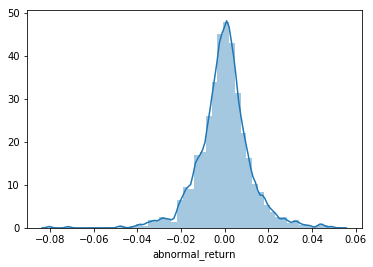

In [22]:
# check distribution of return


sns.distplot(df['abnormal_return']);

# abnormal return follows normal distribution with mean around 0 -> data is balanced

In [23]:
# check flag balance

df['abnormal_return_flag'].value_counts()

 1    21298
-1    21248
Name: abnormal_return_flag, dtype: int64

### Nominal Features

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


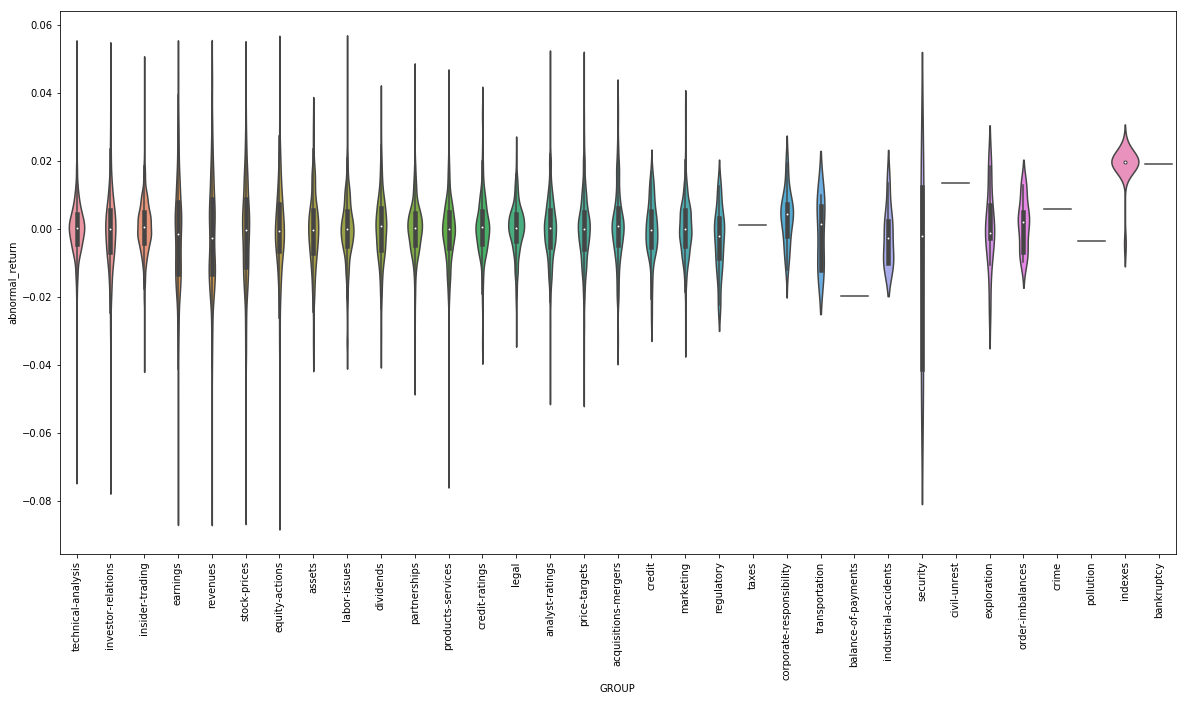

In [24]:
var_x = 'GROUP'
var_y = 'abnormal_return'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (20, 10))
fig = sns.violinplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


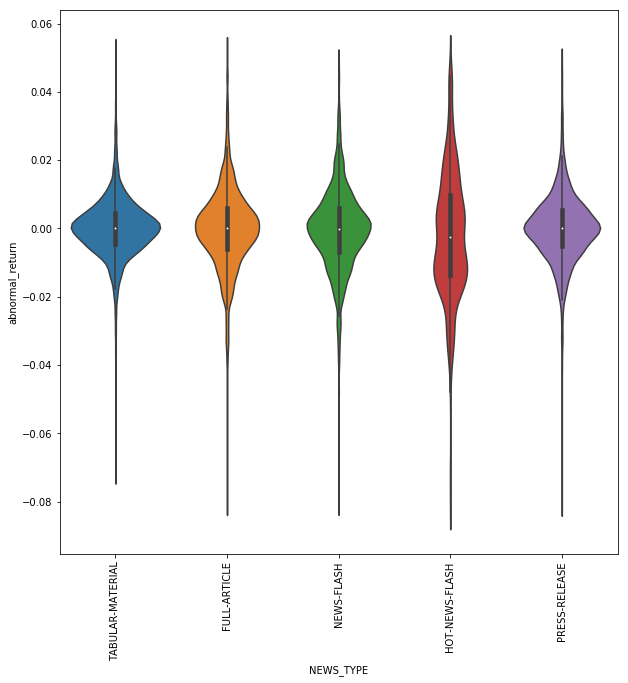

In [25]:
var_x = 'NEWS_TYPE'
var_y = 'abnormal_return'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (10, 10))
fig = sns.violinplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

## Model Training

### Preparing Data for Classification

In [26]:
# assigning feature matrix and output variable

X = df[['RELEVANCE','GROUP', 'ESS','AES','AEV','ENS','ENS_SIMILARITY_GAP', 'ENS_ELAPSED','G_ENS',
        'G_ENS_SIMILARITY_GAP','G_ENS_ELAPSED','NEWS_TYPE','RP_STORY_EVENT_INDEX', 'RP_STORY_EVENT_COUNT',
        'CSS','NIP','PEQ','BEE','BMQ','BAM','BCA','MCQ']]
y = df['abnormal_return_flag']

In [27]:
# transform nominal features to dummy features
X = pd.get_dummies(X)

### Assessing Feature Importance with Random Forests

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
feat_labels = X.columns[0:]
forest = RandomForestClassifier(n_estimators=500, random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

sfm = SelectFromModel(forest, threshold=0.05, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

C:\Users\nicol\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Number of samples that meet this criterion: 31909
 1) AEV                            0.174180
 2) AES                            0.138912
 3) G_ENS_SIMILARITY_GAP           0.102326
 4) NIP                            0.088727
 5) ENS_SIMILARITY_GAP             0.086011
 6) G_ENS_ELAPSED                  0.068195
 7) ESS                            0.051621


### PCA Decomposition

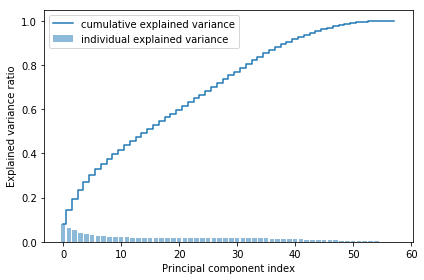

In [29]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(0, 58), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, 58), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Model Selection

In [34]:
# compare different classifiers (note: svc takes very long)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(kernel = 'rbf'),
    GaussianNB(),
    KNeighborsClassifier()
    ]

clf_columns = [['Name',
                'Accuracy Mean', 'Accuracy Mean',
                'Accuracy Std', 'Accuracy Std',
                'Precision Mean', 'Precision Mean',
                'Recall Mean', 'Recall Mean'],
               ['', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test']]


clf_table = pd.DataFrame(columns = clf_columns)

ss = ShuffleSplit(n_splits = 5, random_state = 0)

for i, clf in enumerate(classifiers):
    
    clf_name = clf.__class__.__name__
    clf_table.loc[i, 'Name'] = clf_name
    
    pipe = make_pipeline(PolynomialFeatures(interaction_only=True, include_bias=False),
                         PCA(10),
                         StandardScaler(),
                         clf)
    
    cv = cross_validate(clf, X, y, scoring = ['accuracy', 'precision', 'recall'],
                        return_train_score = True, cv = ss)
    
    clf_table.loc[i, ('Accuracy Mean', 'Train')] = cv['train_accuracy'].mean()
    clf_table.loc[i, ('Accuracy Mean', 'Test')] = cv['test_accuracy'].mean()
    clf_table.loc[i, ('Accuracy Std', 'Train')] = cv['train_accuracy'].std()
    clf_table.loc[i, ('Accuracy Std', 'Test')] = cv['test_accuracy'].std()
    clf_table.loc[i, ('Precision Mean', 'Train')] = cv['train_precision'].mean()
    clf_table.loc[i, ('Precision Mean', 'Test')] = cv['test_precision'].mean()
    clf_table.loc[i, ('Recall Mean', 'Train')] = cv['train_recall'].mean()
    clf_table.loc[i, ('Recall Mean', 'Test')] = cv['test_recall'].mean()

clf_table.sort_values(by = [('Accuracy Mean', 'Test')], ascending = False, inplace = False)
clf_table

Name Accuracy Mean           Accuracy Std              \
                                  Train      Test        Train        Test   
0      LogisticRegression       0.49995  0.503314   0.00129873  0.00426568   
1  RandomForestClassifier      0.985119   0.62369  0.000353635  0.00545605   
2                     SVC      0.970917  0.526722  0.000199303  0.00857657   
3              GaussianNB      0.504724  0.502186  0.000772533  0.00632088   
4    KNeighborsClassifier      0.719041  0.553984  0.000679091  0.00778671   

  Precision Mean           Recall Mean            
           Train      Test       Train      Test  
0       0.500416  0.502312     0.74141  0.746237  
1       0.993255  0.646532    0.976912  0.545663  
2       0.971163  0.544301    0.970736  0.590116  
3       0.502786  0.501137    0.969317  0.965058  
4       0.718612  0.554521    0.721238  0.548096

### Hyperparameter- Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

param_grid = {"max_depth": [3, 10, None],
              "max_features": [1, 'auto', 'log2'],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]
             }

gs = GridSearchCV(estimator = rf, 
                  param_grid = param_grid, 
                  scoring = 'roc_auc', 
                  cv = ss)

gs = gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)

0.7183573519676766
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 3}


In [32]:
#generate training and test accuracy for random forest with several random test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for k in range(5):
    forest = RandomForestClassifier(**gs.best_params_,
                                    random_state=k)
    forest.fit(X_train, y_train)
    #print accuraccy on the training dataset
    #print('Train accuracy for random state ' + str(k) + ': %.3f' % forest.score(X_train, y_train))
    #print accuracy on the test dataset
    print('Test accuracy for random state ' + str(k) + ': %.3f' % forest.score(X_test, y_test))

Test accuracy for random state 0: 0.641
Test accuracy for random state 1: 0.637
Test accuracy for random state 2: 0.637
Test accuracy for random state 3: 0.647
Test accuracy for random state 4: 0.644


### Final Model

In [37]:
clf_table = clf_table.iloc[0:0]

forest = RandomForestClassifier(n_estimators = 500,
                                **gs.best_params_,
                                random_state=0)

clf_name = forest.__class__.__name__
clf_table.loc[0, 'Name'] = clf_name

cv = cross_validate(forest, X, y, scoring = ['accuracy', 'precision', 'recall'],
                    return_train_score = True, cv = ss)

clf_table.loc[0, ('Accuracy Mean', 'Train')] = cv['train_accuracy'].mean()
clf_table.loc[0, ('Accuracy Mean', 'Test')] = cv['test_accuracy'].mean()
clf_table.loc[0, ('Accuracy Std', 'Train')] = cv['train_accuracy'].std()
clf_table.loc[0, ('Accuracy Std', 'Test')] = cv['test_accuracy'].std()
clf_table.loc[0, ('Precision Mean', 'Train')] = cv['train_precision'].mean()
clf_table.loc[0, ('Precision Mean', 'Test')] = cv['test_precision'].mean()
clf_table.loc[0, ('Recall Mean', 'Train')] = cv['train_recall'].mean()
clf_table.loc[0, ('Recall Mean', 'Test')] = cv['test_recall'].mean()

clf_table

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Name Accuracy Mean           Accuracy Std              \
                                  Train      Test        Train        Test   
0  RandomForestClassifier      0.998684  0.679953   6.9293e-05  0.00408255   

  Precision Mean           Recall Mean            
           Train      Test       Train      Test  
0       0.998956  0.679662    0.998414  0.680822